In [1]:
#Import libraries for doing image analysis
from skimage.io import imread
from skimage.transform import resize
from sklearn.ensemble import RandomForestClassifier as RF
import glob
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from sklearn import cross_validation
from sklearn.cross_validation import StratifiedKFold as KFold
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from matplotlib import colors
from pylab import cm
from skimage import segmentation
from skimage.morphology import watershed
from skimage import measure
from skimage import morphology
import numpy as np
import pandas as pd
from scipy import ndimage
from skimage.feature import peak_local_max

# make graphics inline
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/Users/tom/anaconda/envs/py36/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/tom/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from keras import backend as K
print(K.image_data_format())
K.set_image_data_format('channels_first')
print(K.image_data_format())

channels_last
channels_first


In [4]:
# check for GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16118063148174085873
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3282167398
locality {
  bus_id: 1
}
incarnation: 1063493276835867971
physical_device_desc: "device: 0, name: GeForce GTX 950M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


## Importing the data

In [5]:
data_dir = 'data'

In [8]:
df_train_labels = pd.read_csv(os.path.join(data_dir,'train_onelabel.csv'))
df_train_labels.head()

,image,class
0,132103.jpg,0
1,66467.jpg,0
2,9143.jpg,0
3,20630.jpg,0
4,33689.jpg,0


In [9]:
df_label_map = pd.read_csv(os.path.join(data_dir,'label_map.txt'), sep=" ", header=None, names=["label", "class"])
df_label_map.head()

,label,class
0,unknown_unclassified,0
1,unknown_sticks,1
2,protist_star,2
3,copepod_cyclopoid_oithona,3
4,hydromedusae_solmundella,4


## Preparing Training Data

In [27]:
IMG_SIZE = 64
NUM_CLASSES = 121

In [11]:
def preprocess_img(img):
    # rescale to standard size
    img = resize(img, (IMG_SIZE, IMG_SIZE))
    return img

def get_label(file_name):
    return df_train_labels.loc[df_train_labels['image'] == file_name]['class'].values[0]

In [12]:
#get the total training images
number_of_images = 0
for _, _, fileNames in os.walk(os.path.join(data_dir,'train_images')): 
    for fileName in fileNames:
        # Only read in the images
        if fileName[-4:] != ".jpg":
            continue
        number_of_images += 1
        
print('Number of images:', number_of_images)

imgs = []
labels = []
i = 0

print('Reading images...')

for root, _, file_names in os.walk(os.path.join(data_dir,'train_images')): # change in train_images
    for file_name in file_names:
        # Only read in the images
        if fileName[-4:] != ".jpg":
            continue
        
        img_path = "{0}{1}{2}".format(root, os.sep, file_name)
        img = preprocess_img(imread(img_path, as_grey=True))
        imgs.append(img)
        
        label = get_label(file_name)
        labels.append(label)
        
        i += 1
        # report progress for each 5% done  
        report = [int((j+1)*number_of_images/20.) for j in range(20)]
        if i in report: print(np.ceil(i *100.0 / number_of_images), "% done")

Number of images: 24204
Reading images...
5.0 % done
10.0 % done
15.0 % done
20.0 % done
25.0 % done
30.0 % done
35.0 % done
40.0 % done
45.0 % done
50.0 % done
55.0 % done
60.0 % done
65.0 % done
70.0 % done
75.0 % done
80.0 % done
85.0 % done
90.0 % done
95.0 % done
100.0 % done


In [13]:
X = np.array(imgs, dtype='float32')
X.shape

(24204, 64, 64)

In [14]:
X = X.reshape(X.shape[0], 1, IMG_SIZE, IMG_SIZE)
X.shape

(24204, 1, 64, 64)

In [15]:
Y = np_utils.to_categorical(labels)
Y.shape

(24204, 121)

In [16]:
#get the total test images
number_of_images = 0
for _, _, fileNames in os.walk(os.path.join(data_dir,'test_images')): 
    for fileName in fileNames:
        # Only read in the images
        if fileName[-4:] != ".jpg":
            continue
        number_of_images += 1
        
print('Number of images:', number_of_images)

imgs = []
test_img_names = []
i = 0

print('Reading test images...')

for root, _, file_names in os.walk(os.path.join(data_dir,'test_images')): # change in train_images
    for file_name in file_names:
        # Only read in the images
        if fileName[-4:] != ".jpg":
            continue
        
        img_path = "{0}{1}{2}".format(root, os.sep, file_name)
        img = preprocess_img(imread(img_path, as_grey=True))
        imgs.append(img)
        
        test_img_names.append(file_name)
        
        i += 1
        
        report = [int((j+1)*number_of_images/20.) for j in range(20)]
        if i in report: print(np.ceil(i *100.0 / number_of_images), "% done")

Number of images: 6132
Reading test images...
5.0 % done
10.0 % done
15.0 % done
20.0 % done
25.0 % done
30.0 % done
35.0 % done
40.0 % done
45.0 % done
50.0 % done
55.0 % done
60.0 % done
65.0 % done
70.0 % done
75.0 % done
80.0 % done
85.0 % done
90.0 % done
95.0 % done
100.0 % done


In [17]:
X_test = np.array(imgs, dtype='float32')
X_test.shape

(6132, 64, 64)

In [18]:
X_test = X_test.reshape(X_test.shape[0], 1, IMG_SIZE, IMG_SIZE)
X_test.shape

(6132, 1, 64, 64)

## Define Keras Models

In [28]:
def create_model():

    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(1, IMG_SIZE, IMG_SIZE), data_format='channels_first'))
    model.add(keras.layers.LeakyReLU(alpha=0.3))
    model.add(Conv2D(32, (3, 3), data_format='channels_first'))
    model.add(keras.layers.LeakyReLU(alpha=0.3))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same', data_format='channels_first'))
    model.add(keras.layers.LeakyReLU(alpha=0.3))
    model.add(Conv2D(64, (3, 3), data_format='channels_first'))
    model.add(keras.layers.LeakyReLU(alpha=0.3))
    model.add(Conv2D(128, (3, 3), data_format='channels_first'))
    model.add(keras.layers.LeakyReLU(alpha=0.3))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3, 3), data_format='channels_first'))
    model.add(keras.layers.LeakyReLU(alpha=0.3))
    model.add(Conv2D(256, (3, 3), data_format='channels_first'))
    model.add(keras.layers.LeakyReLU(alpha=0.3))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES))
    model.add(Activation('softmax'))
    
    return model

model = create_model()

In [ ]:
from keras.optimizers import SGD

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

In [ ]:
tbCallback = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)

esCallback = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=0, mode='auto')

checkpointCallback = keras.callbacks.ModelCheckpoint('./best_model_checkpoint.hdf5', monitor='val_loss',
                                verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
from random import randint

def random_rot90(x):
    return np.rot90(x, randint(0, 3), axes=(1, 2))

In [426]:
batch_size = 64
epochs = 250

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,
        preprocessing_function=random_rot90)

datagen.fit(X_train)

steps_per_epoch = int(np.ceil(X_train.shape[0] / float(batch_size)))

# Fit the model on the batches generated by datagen.flow() ==> Realtime data augmentation
model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size), 
                    epochs=epochs, validation_data=(X_val, Y_val), verbose=1, 
                            steps_per_epoch=steps_per_epoch, workers=4, callbacks=[tbCallback, checkpointCallback])

Epoch 1/250
303/303 [==============================] - 96s 317ms/step - loss: 4.1166 - acc: 0.0960 - val_loss: 3.8109 - val_acc: 0.1111
Epoch 2/250
303/303 [==============================] - 94s 311ms/step - loss: 3.5782 - acc: 0.1657 - val_loss: 3.1239 - val_acc: 0.2535
Epoch 3/250
303/303 [==============================] - 95s 313ms/step - loss: 3.0755 - acc: 0.2516 - val_loss: 2.5733 - val_acc: 0.3425
Epoch 4/250
303/303 [==============================] - 95s 313ms/step - loss: 2.6945 - acc: 0.3144 - val_loss: 2.2799 - val_acc: 0.3931
Epoch 5/250
303/303 [==============================] - 95s 313ms/step - loss: 2.4367 - acc: 0.3580 - val_loss: 2.0790 - val_acc: 0.4383
Epoch 6/250
303/303 [==============================] - 95s 315ms/step - loss: 2.2689 - acc: 0.3929 - val_loss: 1.9595 - val_acc: 0.4613
Epoch 7/250
303/303 [==============================] - 95s 313ms/step - loss: 2.1300 - acc: 0.4196 - val_loss: 1.8685 - val_acc: 0.4861
Epoch 8/250
303/303 [===========================

Epoch 61/250
303/303 [==============================] - 95s 313ms/step - loss: 1.1618 - acc: 0.6436 - val_loss: 1.0596 - val_acc: 0.6842
Epoch 62/250
303/303 [==============================] - 95s 315ms/step - loss: 1.1456 - acc: 0.6504 - val_loss: 1.0315 - val_acc: 0.6854
Epoch 63/250
303/303 [==============================] - 93s 308ms/step - loss: 1.1577 - acc: 0.6488 - val_loss: 1.0344 - val_acc: 0.6945
Epoch 64/250
303/303 [==============================] - 93s 307ms/step - loss: 1.1393 - acc: 0.6528 - val_loss: 1.0440 - val_acc: 0.6881
Epoch 65/250
303/303 [==============================] - 93s 308ms/step - loss: 1.1477 - acc: 0.6493 - val_loss: 1.0453 - val_acc: 0.6846
Epoch 66/250
303/303 [==============================] - 99s 328ms/step - loss: 1.1341 - acc: 0.6531 - val_loss: 0.9905 - val_acc: 0.7005
Epoch 67/250
303/303 [==============================] - 94s 311ms/step - loss: 1.1331 - acc: 0.6548 - val_loss: 1.0595 - val_acc: 0.6862
Epoch 68/250
303/303 [===================

303/303 [==============================] - 93s 306ms/step - loss: 0.9689 - acc: 0.6934 - val_loss: 0.9644 - val_acc: 0.7131
Epoch 180/250
303/303 [==============================] - 93s 306ms/step - loss: 0.9788 - acc: 0.6950 - val_loss: 0.9299 - val_acc: 0.7197
Epoch 181/250
303/303 [==============================] - 93s 306ms/step - loss: 0.9734 - acc: 0.6945 - val_loss: 0.9390 - val_acc: 0.7153
Epoch 182/250
303/303 [==============================] - 93s 306ms/step - loss: 0.9669 - acc: 0.6999 - val_loss: 0.9329 - val_acc: 0.7199
Epoch 183/250
303/303 [==============================] - 93s 306ms/step - loss: 0.9754 - acc: 0.6916 - val_loss: 0.9386 - val_acc: 0.7199
Epoch 184/250
303/303 [==============================] - 93s 306ms/step - loss: 0.9647 - acc: 0.7018 - val_loss: 0.9879 - val_acc: 0.7174
Epoch 185/250
303/303 [==============================] - 93s 306ms/step - loss: 0.9606 - acc: 0.6984 - val_loss: 0.9423 - val_acc: 0.7197
Epoch 186/250
303/303 [=========================

In [429]:
#model = keras.models.load_model('best_model_checkpoint.hdf5')

In [430]:
# Score trained model

scores = model.evaluate(X_val, Y_val, verbose=1)

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

4841/4841 [==============================] - 10s 2ms/step
Test loss: 0.893533925494
Test accuracy: 0.734972113224


In [431]:
y_pred = model.predict_classes(X_test)
df_submit = pd.DataFrame(list(zip(test_img_names, y_pred)),columns=['image','class'])
df_submit.to_csv('submission', sep=',', index=False)

## Evaluate classification results for validation set

In [ ]:
y_pred_val = model.predict_classes(X_val)

In [ ]:
from sklearn.metrics import classification_report

cr = classification_report(np.argmax(Y_val,axis=1), y_pred_val, target_names=df_label_map['label'] + ' (' + df_label_map['class'].astype(str) + ')')
print(cr)

## Visualize Filters

In [21]:
from keras.models import load_model
from keras import activations
from vis.utils import utils

# Load best performing model to visualize its filters
model = load_model('best_model_checkpoint.hdf5')

# Swap softmax with linear
layer_idx = -1
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

### Visualization Attention

#### Saliency

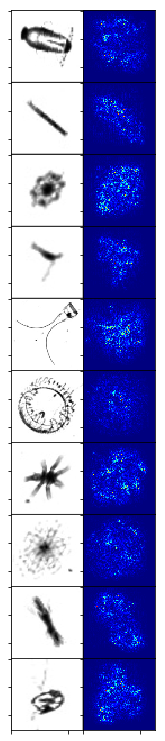

In [22]:
from vis.visualization import visualize_saliency
from matplotlib import gridspec

def plot_saliency(start_class=0, max_items=10):
    class_idx = start_class
    layer_idx = -1
    max_items_plot = max_items
    figscale = 1
    nrow = max_items_plot
    ncol = 2
    
    fig = plt.figure(figsize=(figscale*(ncol+1), figscale*(nrow+1))) 
    gs = gridspec.GridSpec(nrow, ncol,
             wspace=0.0, hspace=0.0, 
             top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
         left=0.5/(ncol+1), right=1-0.5/(ncol+1))
    
   
    for i in range(max_items_plot):
        indices = np.where(Y[:, class_idx] == 1.)[0]
        idx = indices[0]
        
        grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, seed_input=X[idx])
        
        # Plot with 'jet' colormap to visualize as a heatmap.
        ax = plt.subplot(gs[i,0])
        ax.imshow(X[idx].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
        ax = plt.subplot(gs[i,1])
        ax.imshow(grads, cmap='jet')
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        class_idx += 1

plot_saliency()

#### grad-CAM

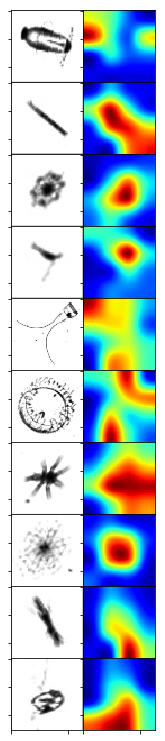

In [23]:
from vis.visualization import visualize_cam


max_heatmaps = 10
nrow = max_heatmaps
ncol = 2
layer_idx = -1
figscale = 1

fig = plt.figure(figsize=(figscale*(ncol+1), figscale*(nrow+1))) 

gs = gridspec.GridSpec(nrow, ncol,
         wspace=0.0, hspace=0.0, 
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
         left=0.5/(ncol+1), right=1-0.5/(ncol+1))

# This corresponds to the Dense linear layer.
for i, class_idx in enumerate(np.arange(max_heatmaps)):    
    indices = np.where(Y[:, class_idx] == 1.)[0]
    idx = indices[0]
    
    ax = plt.subplot(gs[i,0])
    ax.imshow(X[idx].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    grads = visualize_cam(model, layer_idx, filter_indices=class_idx, seed_input=X[idx])
    
    ax = plt.subplot(gs[i,1])
    ax.imshow(grads, cmap='jet')
    ax.set_xticklabels([])
    ax.set_yticklabels([])

### Visualization Activation

In [24]:
def map_class_to_label(class_id):
    return df_label_map[df_label_map['class'] == class_id]['label'].values[0]

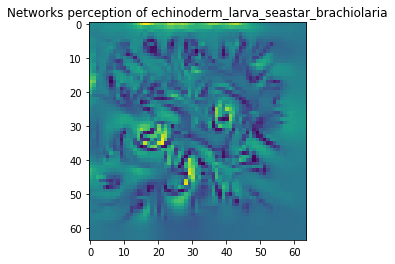

In [25]:
from vis.visualization import visualize_activation

# This is the output node we want to maximize.
filter_idx = 70 # model has high f1-score for class 70
img = visualize_activation(model, layer_idx, filter_indices=filter_idx)
plt.imshow(img[..., 0])
plt.title('Networks perception of {}'.format(map_class_to_label(filter_idx)))

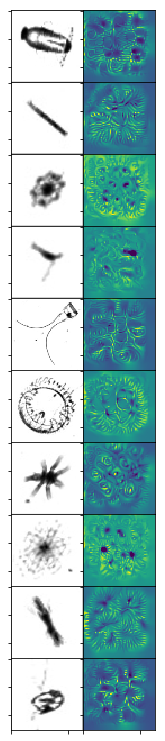

In [26]:
max_activations = 10
nrow = max_activations
ncol = 2
figscale = 1
fig = plt.figure(figsize=((ncol+1)*figscale, (nrow+1)*figscale)) 
gs = gridspec.GridSpec(nrow, ncol,
         wspace=0.0, hspace=0.0, 
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
         left=0.5/(ncol+1), right=1-0.5/(ncol+1))

for i, class_idx in enumerate(np.arange(max_activations)):
    indices = np.where(Y[:, class_idx] == 1.)[0]
    idx = indices[0]
    img = visualize_activation(model, layer_idx, filter_indices=class_idx, input_range=(0., 1.))
    
    ax = plt.subplot(gs[i,0])
    ax.imshow(X[idx].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax = plt.subplot(gs[i,1])
    ax.imshow(img[..., 0])
    ax.set_xticklabels([])
    ax.set_yticklabels([])